In [13]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import os
import pickle
import numpy as np
import pandas as pd
import xarray as xr
from scipy import stats
import scipy.io
from tqdm import tqdm

In [12]:
pca = 'imagenet'
scores_dir = '/home/eric/.brainscore_cache/.result_caching/model_tools.brain_transformation.neural.LayerScores._call/'
object2vec_dir = '/home/eric/datasets/object2vec_new'
benchmark_identifier = 'bonner.Object2Vec.regression=lin'
results = pd.read_csv('../results/object2vec_base_lin.csv')

In [3]:
def load_score(model_identifier):
    filename = f'model_identifier={model_identifier},benchmark_identifier={benchmark_identifier},visual_degrees=8.pkl'
    path = scores_dir + filename
    with open(path, 'rb') as f:
        score = pickle.load(f)
    score = score['data'].raw.raw
    score['layer'] = np.char.add(model_identifier + '-', score.layer)
    return score

scores = xr.concat([load_score(model_id) for model_id in results.model.unique()], dim='layer')

Loading lookup from /home/eric/anaconda3/envs/bs/lib/python3.7/site-packages/brainio_collection/lookup.csv


In [30]:
def correlations(subject_id):
    subjscores = scores.sel(subject_id=subject_id).dropna('neuroid')
    model_order = results.model + '-' + results.layer
    subjscores = subjscores.sel(layer=model_order.tolist())
    subjscores = subjscores.values
    
    effdims = results[f'effective_dimensionality_{pca}'].values
    
    rs = []
    for i in tqdm(range(subjscores.shape[1])):
        r, _ = stats.spearmanr(effdims, subjscores[:, i])
        rs.append(r)
    rs = np.array(rs)

    return rs

subj1_corr = correlations(1)
subj2_corr = correlations(2)
subj3_corr = correlations(3)
subj4_corr = correlations(4)

100%|██████████| 29970/29970 [00:17<00:00, 1667.30it/s]


In [31]:
def fill_nans(rs, subject_id):
    file = os.path.join(object2vec_dir, 'fmri', f'subj{subject_id:03}', 'stacked_means.mat')
    reliablestack = scipy.io.loadmat(file)['stacked'][0, 0]
    voxels = reliablestack[0]
    valid_indices = ~np.isnan(voxels).any(axis=0)
    rs_filled = np.zeros((voxels.shape[1],), dtype=rs.dtype)
    rs_filled[valid_indices] = rs
    return rs_filled

subj1_corr = fill_nans(subj1_corr, 1)
subj2_corr = fill_nans(subj2_corr, 2)
subj3_corr = fill_nans(subj3_corr, 3)
subj4_corr = fill_nans(subj4_corr, 4)

In [32]:
scipy.io.savemat('../results/subj1_correlations.mat', 
                 {'spearmanr': subj1_corr})
scipy.io.savemat('../results/subj2_correlations.mat', 
                 {'spearmanr': subj2_corr})
scipy.io.savemat('../results/subj3_correlations.mat', 
                 {'spearmanr': subj3_corr})
scipy.io.savemat('../results/subj4_correlations.mat', 
                 {'spearmanr': subj4_corr})

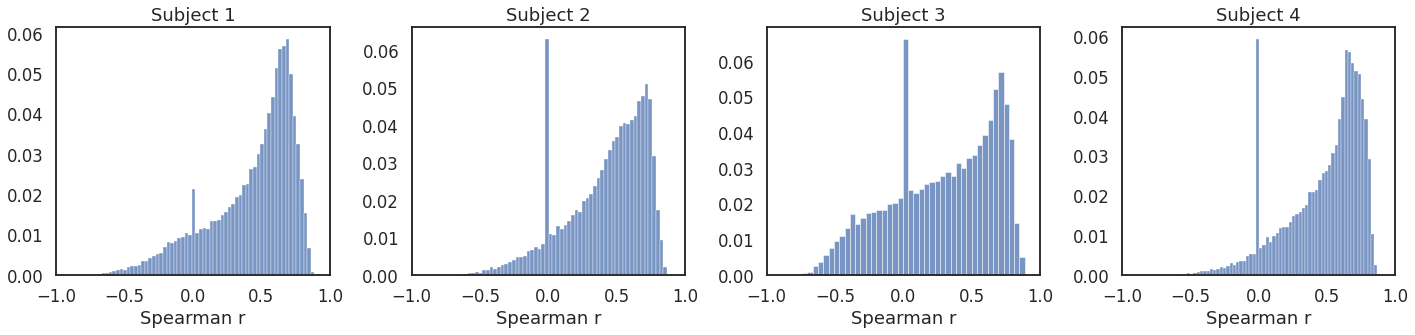

In [33]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style='white', context='talk')

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
sns.histplot(subj1_corr, stat='probability', ax=axs[0])
sns.histplot(subj2_corr, stat='probability', ax=axs[1])
sns.histplot(subj3_corr, stat='probability', ax=axs[2])
sns.histplot(subj4_corr, stat='probability', ax=axs[3])
axs[0].set(xlim=(-1, 1), xlabel='Spearman r', ylabel=None, title='Subject 1')
axs[1].set(xlim=(-1, 1), xlabel='Spearman r', ylabel=None, title='Subject 2')
axs[2].set(xlim=(-1, 1), xlabel='Spearman r', ylabel=None, title='Subject 3')
axs[3].set(xlim=(-1, 1), xlabel='Spearman r', ylabel=None, title='Subject 4')

fig.tight_layout()
plt.show()